In [ ]:
!gdown https://drive.google.com/uc?id=1m_ecAmkgf34bgnoZrN0JjG-i6_HuPpGn

Downloading...
From (original): https://drive.google.com/uc?id=1m_ecAmkgf34bgnoZrN0JjG-i6_HuPpGn
From (redirected): https://drive.google.com/uc?id=1m_ecAmkgf34bgnoZrN0JjG-i6_HuPpGn&confirm=t&uuid=d0e113a0-7257-4002-a0f6-868808f539d4
To: /content/flare_2022_splitted.zip
100% 290M/290M [00:06<00:00, 48.0MB/s]


In [ ]:
!unzip /content/flare_2022_splitted.zip

Streaming output truncated to the last 5000 lines.
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_168_Aorta.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_892_Aorta.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_768_Aorta.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_1226_Liver.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_1367_Inferior_Vena_Cava.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_976_Inferior_Vena_Cava.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_838_Liver.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_520_Liver.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_235_Aorta.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_196_Aorta.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_30_Liver.png  
  inflati

In [ ]:
!pip install torchmetrics
from torchmetrics.segmentation import GeneralizedDiceScore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
from torchvision import transforms
import torch
import random
import json
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import CLIPSegProcessor
import time
from torch.optim.lr_scheduler import CosineAnnealingLR
from transformers import CLIPSegProcessor
from torch.utils.tensorboard import SummaryWriter

In [ ]:
class CLIPSegTrainingDataset(Dataset):
    def __init__(self):
        self.image_dir = os.path.join("/content/flare_2022_splitted/prepared_train_dataset/images")
        self.mask_dir = os.path.join("/content/flare_2022_splitted/prepared_train_dataset/masks")

        with open(os.path.join("/content/flare_2022_splitted/prepared_train_dataset/metadata.json")) as f:
            self.metadata = json.load(f)

        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        sample = self.metadata[idx]

        img_path = os.path.join(self.image_dir, sample["image"])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        mask_path = os.path.join(self.mask_dir, sample["mask"])
        mask = Image.open(mask_path)
        mask = transforms.ToTensor()(mask)

        text_prompt = sample["text_prompt"]

        return image, text_prompt, mask

In [ ]:
class CLIPSegValidationDataset(Dataset):
    def __init__(self):
        self.image_dir = os.path.join("/content/flare_2022_splitted/prepared_val_dataset/images")
        self.mask_dir = os.path.join("/content/flare_2022_splitted/prepared_val_dataset/masks")

        with open(os.path.join("/content/flare_2022_splitted/prepared_val_dataset/metadata.json")) as f:
            self.metadata = json.load(f)

        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        sample = self.metadata[idx]

        img_path = os.path.join(self.image_dir, sample["image"])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        mask_path = os.path.join(self.mask_dir, sample["mask"])
        mask = Image.open(mask_path)
        mask = transforms.ToTensor()(mask)

        text_prompt = sample["text_prompt"]

        return image, text_prompt, mask

In [ ]:
train_dataset = CLIPSegTrainingDataset()
val_dataset = CLIPSegValidationDataset()

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
from typing import Optional

from torch import nn
import torch
from transformers import CLIPSegForImageSegmentation


class CLIPSeg(nn.Module):
    def __init__(
        self,
        clipseg_hf_api: str,
        freeze_encoder: bool = True,
        freeze_decoder: bool = False,
    ) -> None:
        super().__init__()

        self.clipseg = CLIPSegForImageSegmentation.from_pretrained(clipseg_hf_api)

        self.clipseg.clip.requires_grad_(not freeze_encoder)
        self.clipseg.decoder.requires_grad_(not freeze_decoder)

    def forward(
        self,
        input_ids:torch.Tensor,
        pixel_values:torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        **kwargs
    ) -> torch.Tensor:

        B, C, H, W = pixel_values.shape
        outputs = self.clipseg(
            input_ids=input_ids,
            pixel_values=pixel_values,
            attention_mask=attention_mask
        )

        return outputs.logits.view(B, 1, H, W)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clipseg_hf_api = "CIDAS/clipseg-rd16"

model = CLIPSeg(
    clipseg_hf_api=clipseg_hf_api
).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/600M [00:00<?, ?B/s]

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 149884418


In [ ]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    return total_params, trainable_params, non_trainable_params

total_params, trainable_params, non_trainable_params = count_parameters(model)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")
print(f"Percentage of trainable parameters: {trainable_params/total_params*100:.2f}%")

Total parameters: 149,884,418
Trainable parameters: 263,681
Non-trainable parameters: 149,620,737
Percentage of trainable parameters: 0.18%


In [ ]:
processor = CLIPSegProcessor.from_pretrained(clipseg_hf_api, do_rescale=False)

learning_rate = 0.001
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=20)

criterion = nn.BCEWithLogitsLoss()

train_dice_metric = GeneralizedDiceScore(num_classes=2, weight_type='simple').to(device)
val_dice_metric = GeneralizedDiceScore(num_classes=2, weight_type='simple').to(device)

patience = 3
counter = 0
best_dice = 0

writer = SummaryWriter()

start_time = time.time()

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    epoch_start = time.time()

    if counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

    model.train()
    total_loss, total_dice = 0, 0

    for images, expressions, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        inputs = processor(text=expressions, images=images, return_tensors="pt", padding=True)
        input_ids, pixel_values, attention_mask = inputs['input_ids'].to(device), inputs['pixel_values'].to(device), inputs['attention_mask'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)
        logits_resized = F.interpolate(logits, size=masks.shape[2:], mode='bilinear', align_corners=False).unsqueeze(1)
        loss = criterion(logits_resized.squeeze(1), masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds_binary = (torch.sigmoid(logits_resized) > 0.5).float().squeeze(2)
        total_dice += train_dice_metric(preds_binary, masks.long()).item()

    avg_train_loss = total_loss / len(train_loader)
    avg_train_dice = total_dice / len(train_loader)

    # Validation Loop
    model.eval()
    val_loss, val_dice = 0, 0
    with torch.no_grad():
        for images, expressions, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            inputs = processor(text=expressions, images=images, return_tensors="pt", padding=True)
            input_ids, pixel_values, attention_mask = inputs['input_ids'].to(device), inputs['pixel_values'].to(device), inputs['attention_mask'].to(device)

            logits = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)
            logits_resized = F.interpolate(logits, size=masks.shape[2:], mode='bilinear', align_corners=False).unsqueeze(1)
            loss = criterion(logits_resized.squeeze(1), masks)
            val_loss += loss.item()
            preds_binary = (torch.sigmoid(logits_resized) > 0.5).float().squeeze(2)
            val_dice += val_dice_metric(preds_binary, masks.long()).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)

    writer.add_scalar('Loss/train', avg_train_loss, epoch)
    writer.add_scalar('Loss/val', avg_val_loss, epoch)
    writer.add_scalar('Dice/train', avg_train_dice, epoch)
    writer.add_scalar('Dice/val', avg_val_dice, epoch)

    epoch_end = time.time()
    epoch_duration = epoch_end - epoch_start
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | Train Dice: {avg_train_dice:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f} | "
          f"Time: {epoch_duration:.2f} sec")

    scheduler.step()

    if avg_val_dice > best_dice:
        best_dice = avg_val_dice
        counter = 0
    else:
        counter += 1

total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f} seconds")

writer.close()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/600M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


Epoch [1/20] | Train Loss: 0.0426 | Train Dice: 0.0894 | Val Loss: 0.0295 | Val Dice: 0.1508 | Time: 477.20 sec
Epoch [2/20] | Train Loss: 0.0212 | Train Dice: 0.2185 | Val Loss: 0.0204 | Val Dice: 0.2708 | Time: 466.76 sec
Epoch [3/20] | Train Loss: 0.0156 | Train Dice: 0.3317 | Val Loss: 0.0176 | Val Dice: 0.3497 | Time: 469.59 sec
Epoch [4/20] | Train Loss: 0.0134 | Train Dice: 0.4390 | Val Loss: 0.0164 | Val Dice: 0.4632 | Time: 469.49 sec
Epoch [5/20] | Train Loss: 0.0119 | Train Dice: 0.5342 | Val Loss: 0.0162 | Val Dice: 0.3851 | Time: 464.27 sec
Epoch [6/20] | Train Loss: 0.0110 | Train Dice: 0.5740 | Val Loss: 0.0145 | Val Dice: 0.5140 | Time: 461.17 sec
Epoch [7/20] | Train Loss: 0.0103 | Train Dice: 0.6232 | Val Loss: 0.0148 | Val Dice: 0.4748 | Time: 451.05 sec
Epoch [8/20] | Train Loss: 0.0098 | Train Dice: 0.6409 | Val Loss: 0.0140 | Val Dice: 0.5087 | Time: 464.21 sec
Epoch [9/20] | Train Loss: 0.0094 | Train Dice: 0.6631 | Val Loss: 0.0134 | Val Dice: 0.5698 | Time: 465

train time = 2 hours 34 minutes

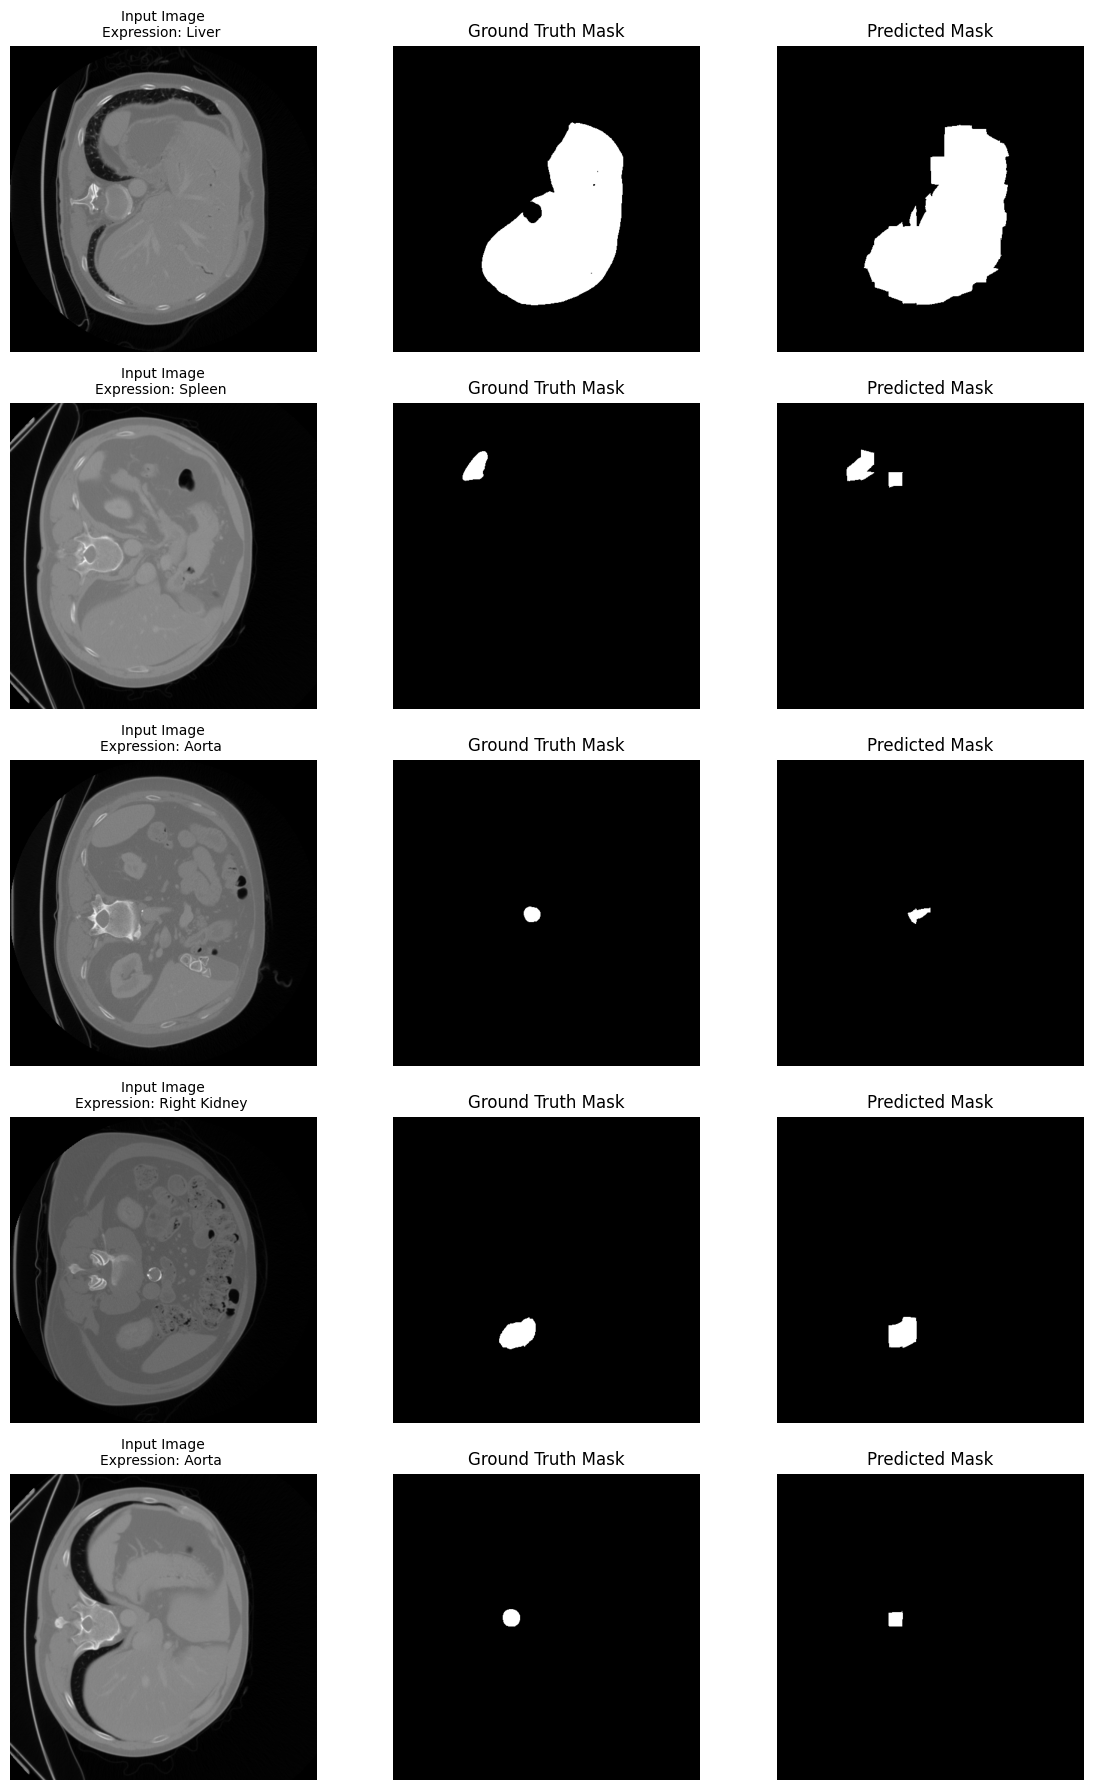

In [ ]:
model.eval()

images_batch, expressions_batch, masks_batch = next(iter(train_loader))

random_indices = random.sample(range(len(images_batch)), 5)

images = images_batch[random_indices].to(device)
masks = masks_batch[random_indices].to(device)
expressions = [expressions_batch[i] for i in random_indices]

inputs = processor(text=expressions, images=images, return_tensors="pt", padding=True)
input_ids = inputs['input_ids'].to(device)
pixel_values = inputs['pixel_values'].to(device)
attention_mask = inputs['attention_mask'].to(device)

with torch.no_grad():
    logits = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)

logits_resized = F.interpolate(logits, size=masks.shape[2:], mode='bilinear', align_corners=False)
pred_masks = (torch.sigmoid(logits_resized) > 0.5).float()

images = images.cpu().numpy().transpose(0, 2, 3, 1)
masks = masks.cpu().numpy()
pred_masks = pred_masks.cpu().numpy()

fig, axes = plt.subplots(5, 3, figsize=(12, 18))

for i in range(5):
    axes[i, 0].imshow(images[i])
    axes[i, 0].set_title(f"Input Image\nExpression: {expressions[i]}", fontsize=10)
    axes[i, 0].axis("off")

    axes[i, 1].imshow(masks[i].squeeze(), cmap="gray")
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(pred_masks[i].squeeze(), cmap="gray")
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

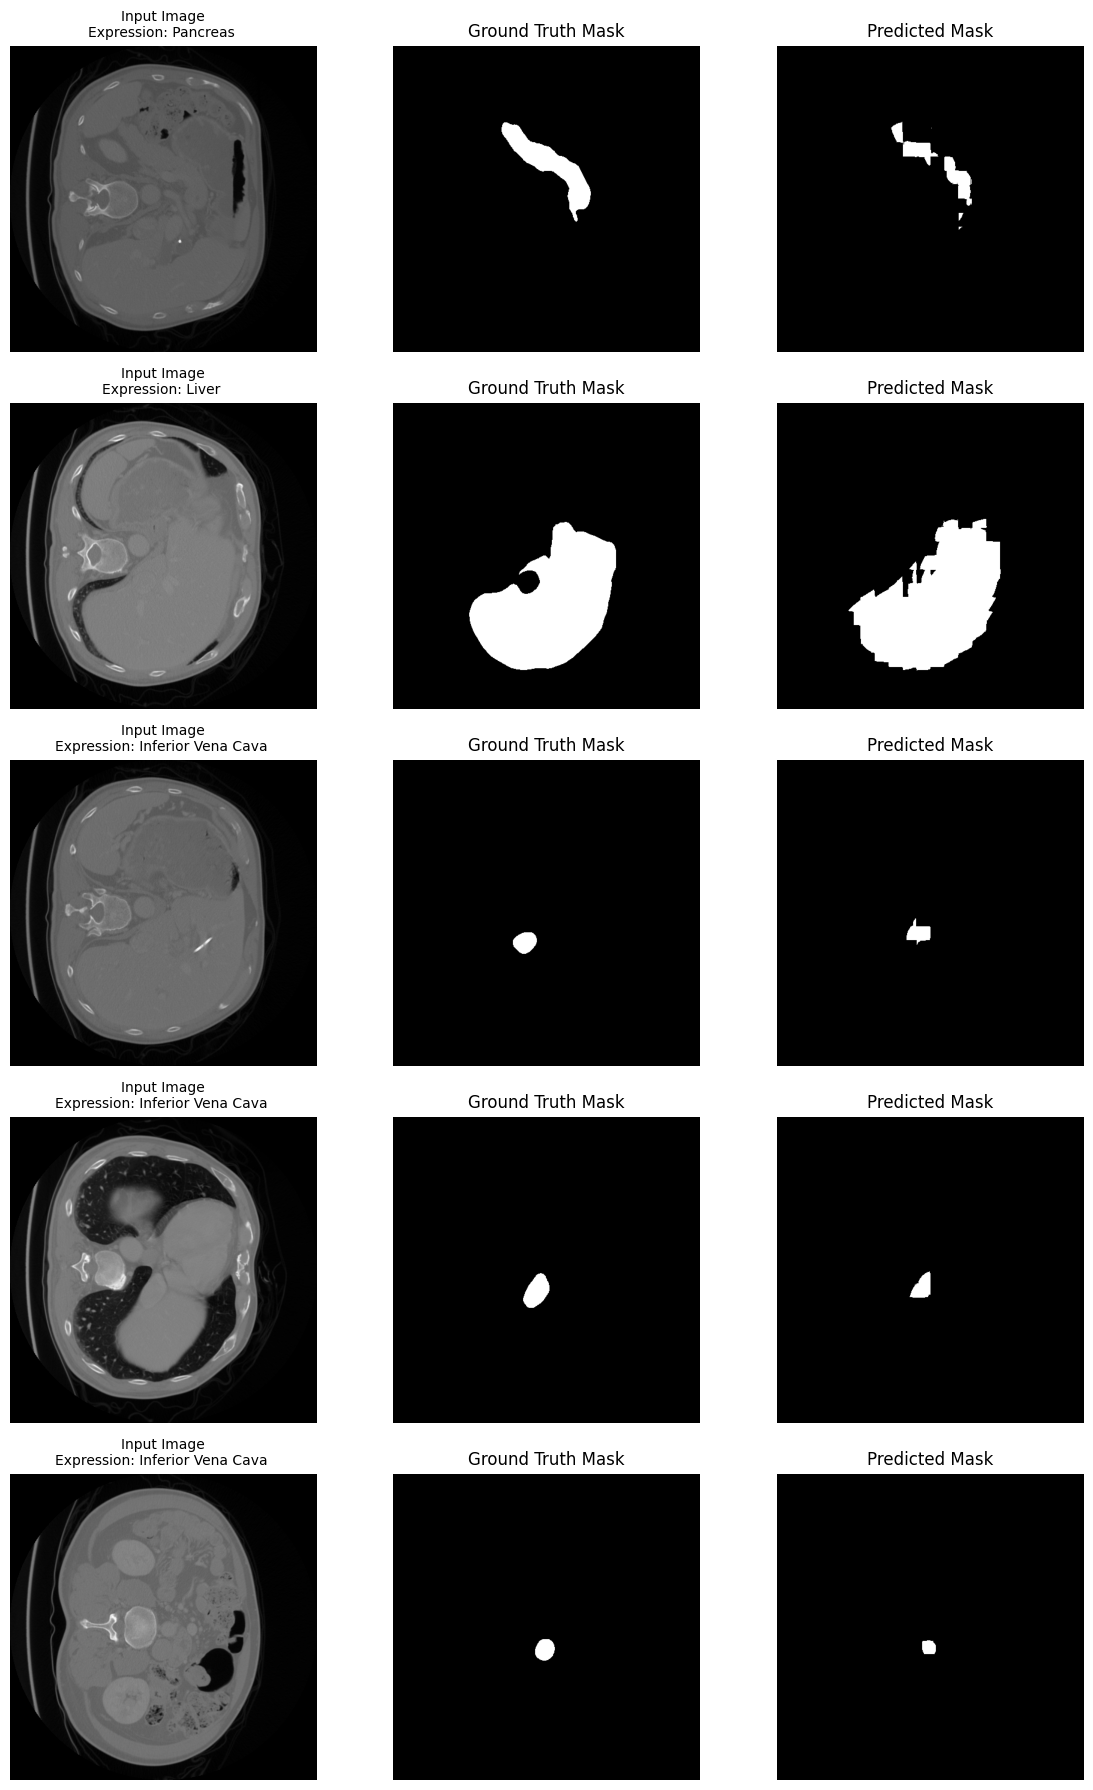

In [ ]:
model.eval()

images_batch, expressions_batch, masks_batch = next(iter(val_loader))

random_indices = random.sample(range(len(images_batch)), 5)

images = images_batch[random_indices].to(device)
masks = masks_batch[random_indices].to(device)
expressions = [expressions_batch[i] for i in random_indices]

inputs = processor(text=expressions, images=images, return_tensors="pt", padding=True)
input_ids = inputs['input_ids'].to(device)
pixel_values = inputs['pixel_values'].to(device)
attention_mask = inputs['attention_mask'].to(device)

with torch.no_grad():
    logits = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)

logits_resized = F.interpolate(logits, size=masks.shape[2:], mode='bilinear', align_corners=False)
pred_masks = (torch.sigmoid(logits_resized) > 0.5).float()

images = images.cpu().numpy().transpose(0, 2, 3, 1)
masks = masks.cpu().numpy()
pred_masks = pred_masks.cpu().numpy()

fig, axes = plt.subplots(5, 3, figsize=(12, 18))

for i in range(5):
    axes[i, 0].imshow(images[i])
    axes[i, 0].set_title(f"Input Image\nExpression: {expressions[i]}", fontsize=10)
    axes[i, 0].axis("off")

    axes[i, 1].imshow(masks[i].squeeze(), cmap="gray")
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(pred_masks[i].squeeze(), cmap="gray")
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()